Relationship Between Crypto and Tech

The correlation between the tech and crypto sectors have increased over the last two years. This article below discusses the matter. Correlation between Bitcoin and stocks: https://www.nasdaq.com/articles/study-shows-recent-correlation-between-bitcoin-and-stocks-is-temporary

Here I look to show how much variance in different cryptocurrencies is explained by the variance in NASDAQ or other assets over time through using a rolling Rsquared.

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import yfinance as yf
import os
import numpy as np

In [16]:
class rsquared:
    import yfinance as yf
    
    def __init__(self, ticker_x: list, ticker_y: list):
        """Tickers are passed as lists of strings."""
        self.ticker_x = ticker_x
        self.ticker_y = ticker_y
        
    def ticker_rolling_rsquared(self, period = "1mo", interval = "1d", actions = False, OHLC="Close", window = 3):
        """Takes a list of tickers and finds the rolling rsquared of them. Reference this for yf help: https://algotrading101.com/learn/yfinance-guide/"""
        ret_x = {}
        ret_y = {}
        
        for ticker in self.ticker_x:
            data_x = self.get_data(str(ticker), period = period, interval = interval, actions = actions)
            ret_x[ticker+"_"+OHLC] = self.get_returns(data_x)[OHLC]
            
        for ticker in self.ticker_y:
            data_y = self.get_data(str(ticker), period = period, interval = interval, actions = actions)
            ret_y[ticker+"_"+OHLC] = self.get_returns(data_y)[OHLC]

        df_ret_x = pd.DataFrame(ret_x).dropna()
        df_ret_y = pd.DataFrame(ret_y).dropna()
        

        self.rolling_rsquared(df_ret_x, df_ret_y, window)
        
        
    def ticker_rolling_correlation(self, period = "1mo", interval = "1d", actions = False, OHLC="Close", window = 3):
        """Takes a list of tickers and finds the rolling correlation of them. Reference this for yf help: https://algotrading101.com/learn/yfinance-guide/"""
        
        ret_x = {}
        ret_y = {}
        
        for ticker in self.ticker_x:
            data_x = self.get_data(str(ticker), period = period, interval = interval, actions = actions)
            ret_x[ticker+"_"+OHLC] = self.get_returns(data_x)[OHLC]
            
        for ticker in self.ticker_y:
            data_y = self.get_data(str(ticker), period = period, interval = interval, actions = actions)
            ret_y[ticker+"_"+OHLC] = self.get_returns(data_y)[OHLC]
            

        df_ret_x = pd.DataFrame(ret_x).dropna()
        df_ret_y = pd.DataFrame(ret_y).dropna()
        
        
        self.rolling_correlation(df_ret_x, df_ret_y, window)
    

    def get_data(self, ticker, period = "1mo", interval = "1d", actions = False):
        """Takes ticker as required parameter and returns historical price data. Uses parameters from yfinance. 
        Actions = False means that dividends and stock split data is not returned. All columns are adjusted prices. WARNING:
        DOESN'T WORK WITH HOURLY Intervals between cryptos and equities due to equities returning on the half hour"""
        x_tick = yf.Ticker(str(ticker))
        x_hist = x_tick.history(period = period, interval = interval, actions = actions)
        if x_hist.index.tzinfo is not None:
            x_hist.index = pd.to_datetime(x_hist.index).tz_convert("UCT")
            return x_hist
        else:
            return x_hist


    def plot_data(self, data, label): #for plotting data
        data.plot(label = label)
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title(ticker + " Price")
        plt.show()
        

    def get_returns(self, x_hist):
        """Takes historical data as required parameter."""
        x_ret = x_hist.pct_change().replace(np.inf, np.nan).dropna()
        return x_ret

    def get_rsquared(self, x_ret, y_ret):
        """Parameters are two different returns data. Only pass one column of returns per parameter. Returns rsquared."""

        x_ret1 = sm.add_constant(x_ret)
        x_ret1.columns = ["Constant","x_ret"]
        returns = x_ret1.join(y_ret, how = "inner")
        returns.columns = ["Constant","x_ret", "y_ret"]
        results = sm.OLS(returns["y_ret"], returns[["Constant","x_ret"]]).fit()
        return results.rsquared


    def tick_to_corr(self, ticker1, ticker2, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        """Takes two tickers and returns adjusted"""
        x_hist = get_data(ticker1, period = period, interval = interval, actions = actions)
        y_hist = get_data(ticker2, period = period, interval = interval, actions = actions)

        x_ret = get_returns(x_hist)
        y_ret = get_returns(y_hist)

        rsquared = get_correlation(y_ret[OHLC],x_ret[OHLC])

        print("R-Squared: " + str(rsquared))
        return rsquared

    
    def rolling_rsquared(self, df_ret_x, df_ret_y, window=3):
         for col_x in df_ret_x.columns:
            no_of_comps = df_ret_y.shape[1]
            
            if no_of_comps == 1:
                figure, axis = plt.subplots(1,1)
            elif no_of_comps%2 == 0:
                figure, axis = plt.subplots(int((no_of_comps)/2),2, figsize = (20,8))
            else:
                figure, axis = plt.subplots(int((0.5+no_of_comps)/2),2,figsize = (20,8))
            
            for i, col_y in enumerate(df_ret_y.columns):
            
                if (df_ret_x[[col_x]].shape[0]> window) and (df_ret_y[[col_y]].shape[0] > window):
                    
                    returns = df_ret_x[[col_x]].merge(df_ret_y[[col_y]],how="inner", left_index=True, right_index=True)
                    
                    new_index = df_ret_x.index.intersection(df_ret_y.index, None)

                    df_ret_x = df_ret_x.loc[new_index] #gives them a shared index
                    df_ret_y = df_ret_y.loc[new_index]
                    
                    rsquared = df_ret_x[col_x].rolling(window).corr(df_ret_y[col_y]).dropna()**2
                    
                    p = figure.axes[i]
                    p.plot(df_ret_x[[col_x]], color='blue', label=col_x)
                    p.plot(df_ret_y[[col_y]], color = 'red', label = col_y)
                    p.plot(rsquared, color = 'green', label="R-Squared")
                    p.set_title(col_y, fontsize=12)
                    p.legend()
                    p.tick_params(labelrotation=45)

                else:
                    print("ValuerError: Window integer must be less than the rows of data provided")
                    return
                
            figure.suptitle("Rolling R-Squared with " + col_x, fontsize= 16)  
            plt.subplots_adjust(left=None,
                                bottom=None,
                                right=None,
                                top=None,
                                wspace=0.1,
                                hspace=0.6)
            plt.show()
                    

    def rolling_correlation(self, df_ret_x, df_ret_y, window=3):
        
        for col_x in df_ret_x.columns:
            no_of_comps = df_ret_y.shape[1]
            
            if no_of_comps == 1:
                figure, axis = plt.subplots(1,1)
            elif no_of_comps%2 == 0:
                figure, axis = plt.subplots(int((no_of_comps)/2),2, figsize = (20,8))
            else:
                figure, axis = plt.subplots(int((0.5+no_of_comps)/2),2, figsize = (20,8))
            
            for i, col_y in enumerate(df_ret_y.columns):
            
                if (df_ret_x[[col_x]].shape[0]> window) and (df_ret_y[[col_y]].shape[0] > window):
                    
                    returns = df_ret_x[[col_x]].merge(df_ret_y[[col_y]],how="inner", left_index=True, right_index=True)
                    
                    new_index = df_ret_x.index.intersection(df_ret_y.index, None)

                    df_ret_x = df_ret_x.loc[new_index] #gives them a shared index
                    df_ret_y = df_ret_y.loc[new_index]
                    
                    rsquared = df_ret_x[col_x].rolling(window).corr(df_ret_y[col_y]).dropna()
                    
                    p = figure.axes[i]
                    p.plot(df_ret_x[[col_x]], color='blue', label=col_x)
                    p.plot(df_ret_y[[col_y]], color = 'red', label = col_y)
                    p.plot(rsquared, color = 'green', label="Correlation")
                    p.set_title(col_y, fontsize=12)
                    p.legend()
                    p.tick_params(labelrotation=45)

                else:
                    print(df_ret_y[[col_x]])
                    print(df_ret_y[[col_y]])
                    print("ValuerError: Window integer must be less than the rows of data provided")
                    return
                
            figure.suptitle("Rolling Correlations with " + col_x, fontsize= 16)    
            plt.subplots_adjust(left=None,
                                bottom=None,
                                right=None,
                                top=None,
                                wspace=0.1,
                                hspace=0.6)
            plt.show()
                    


               



It can be seen below that over the last two years, the proportion that BTC-USD's and other cyrptocurrencies' variance are explained the variance in the NASDAQ and SPLG has increased noticably beginning around January 2022.

Noticeably, Ethereum, NEAR, and Matic are now near all time highs with their R-Squared with Bitcoin.

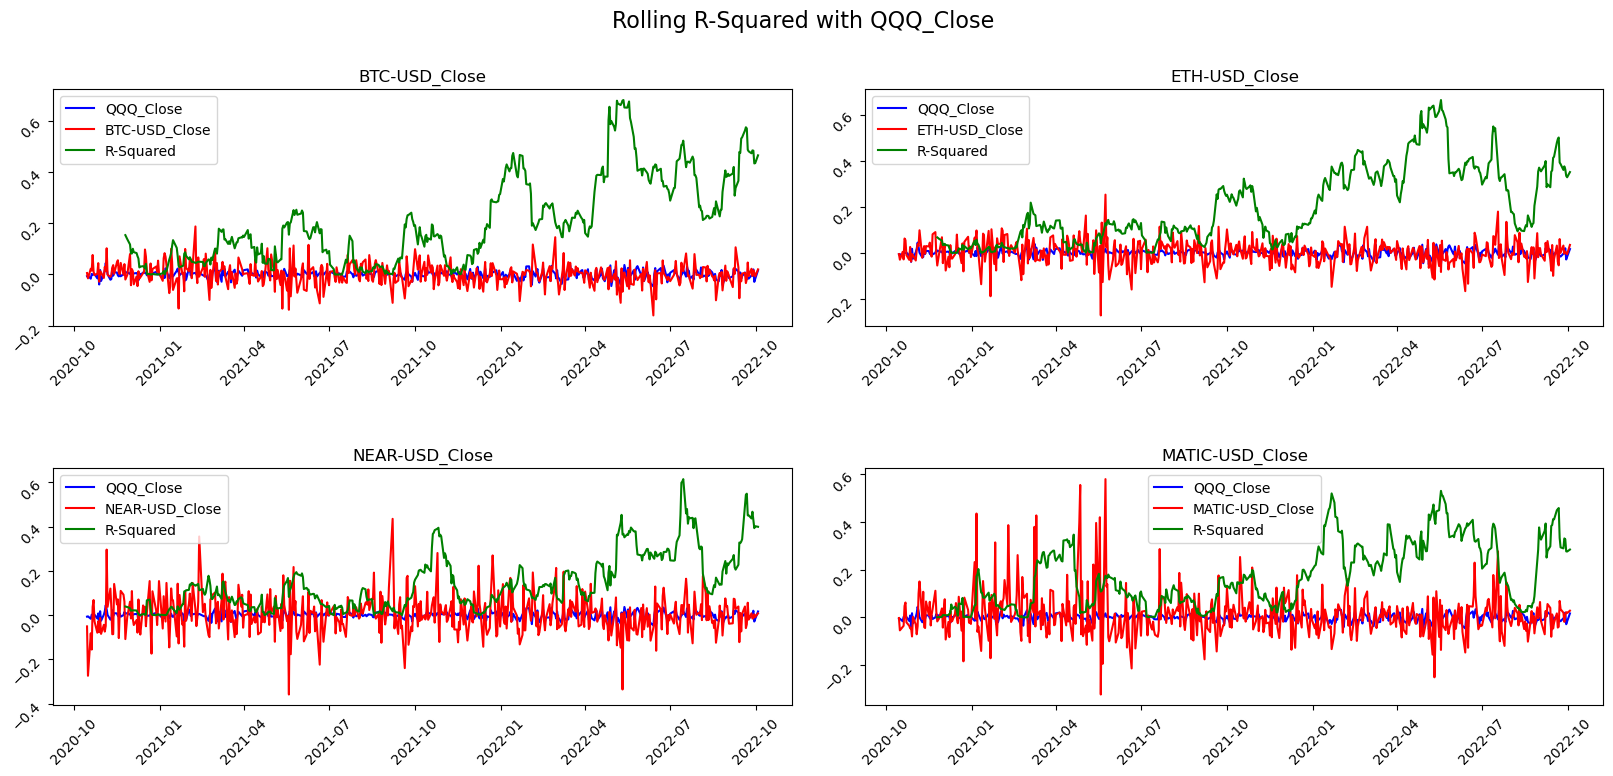

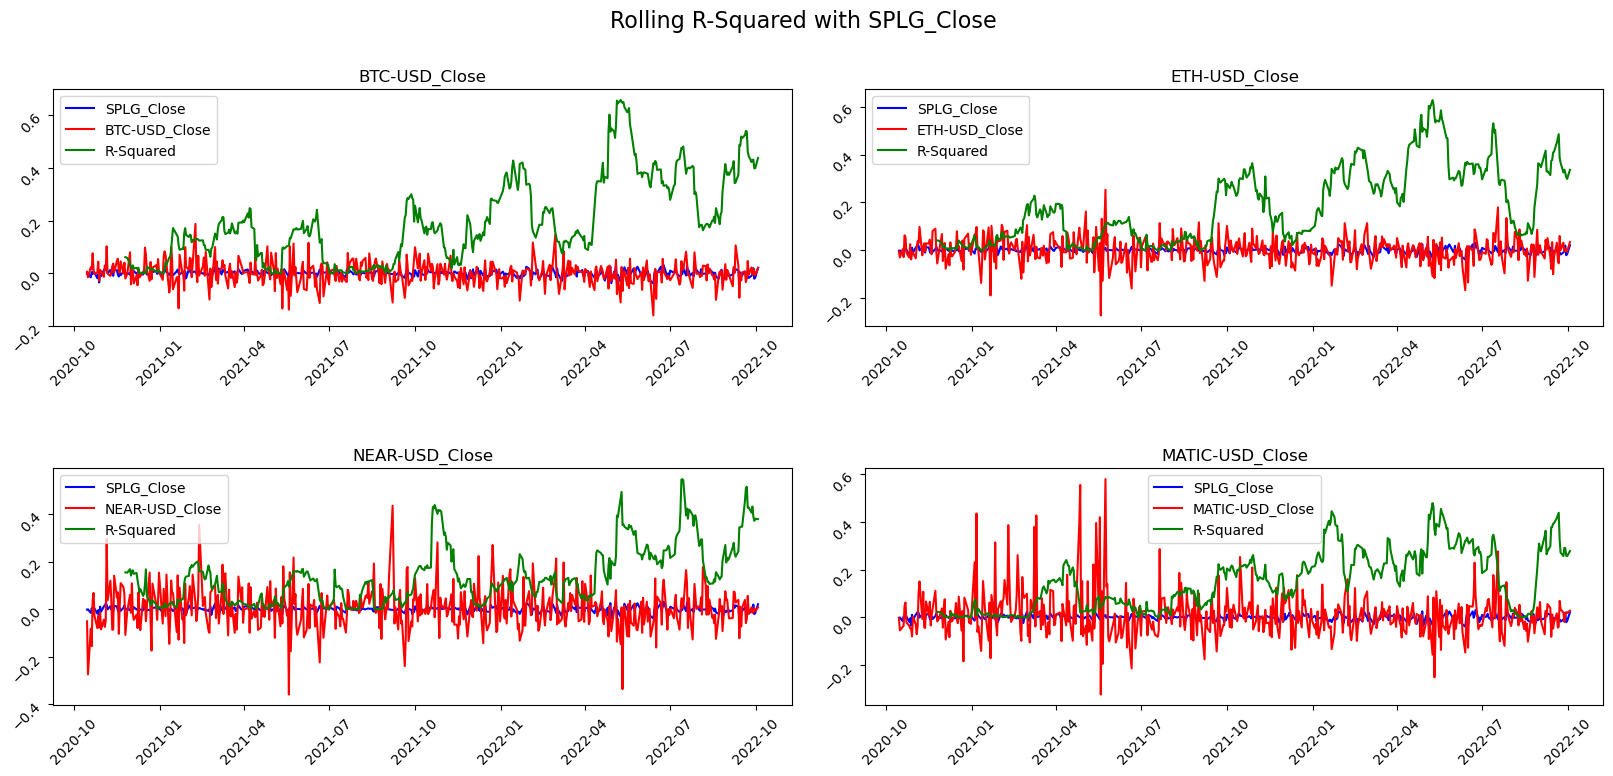

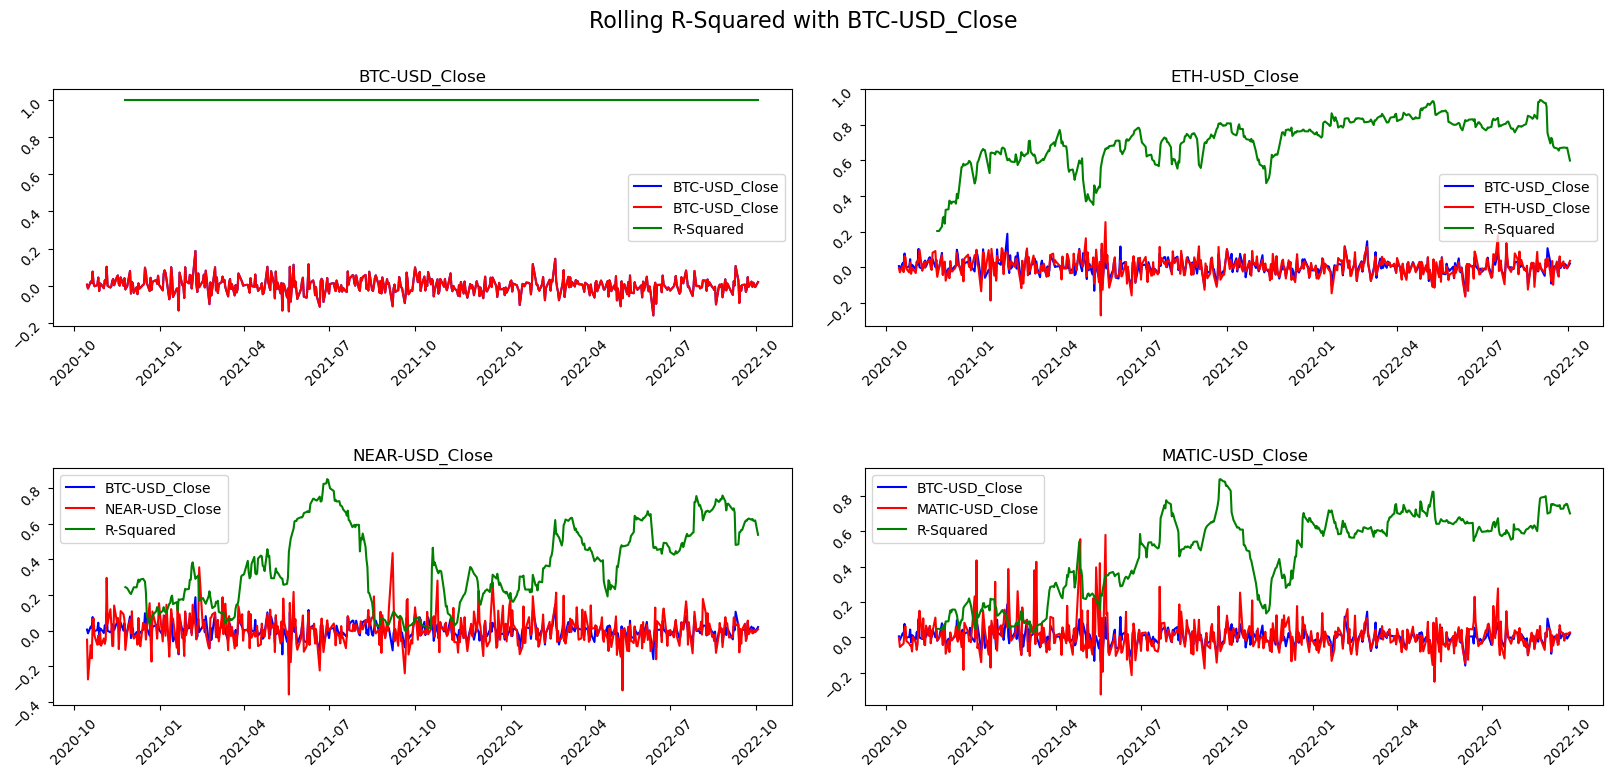

In [17]:
r2_new = rsquared(["QQQ","SPLG", "BTC-USD"],["BTC-USD","ETH-USD","NEAR-USD","MATIC-USD"])
r2_new.ticker_rolling_rsquared(period = "2y", interval='1d', window = 30)

Below, it can be seen that the volatility of rsquared decreases as the amount of data used per rolling rsquared increases but each chart continues to show that there has been an increases in the proportion of Bitcoin's variance explained by the variance of the NASDAQ.

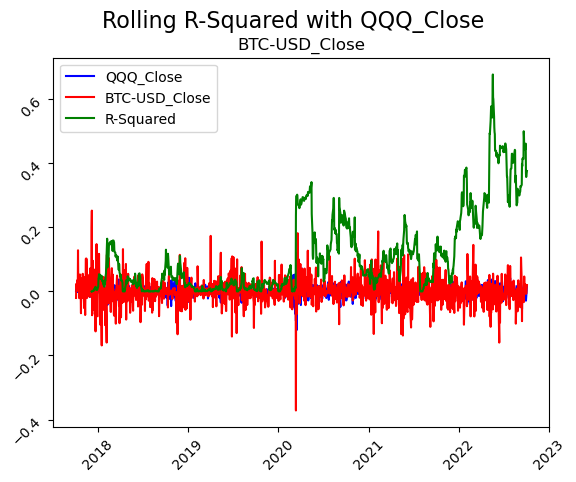

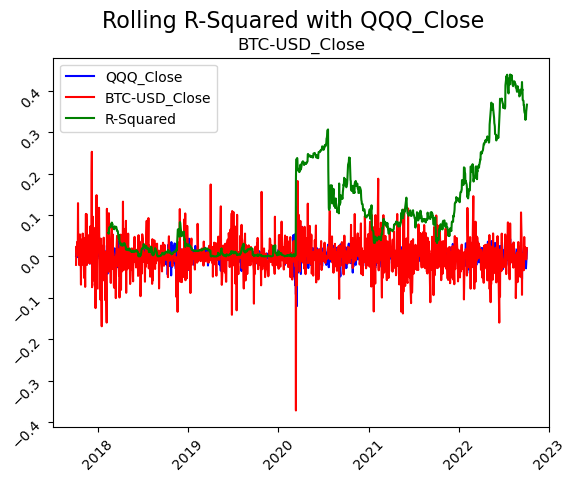

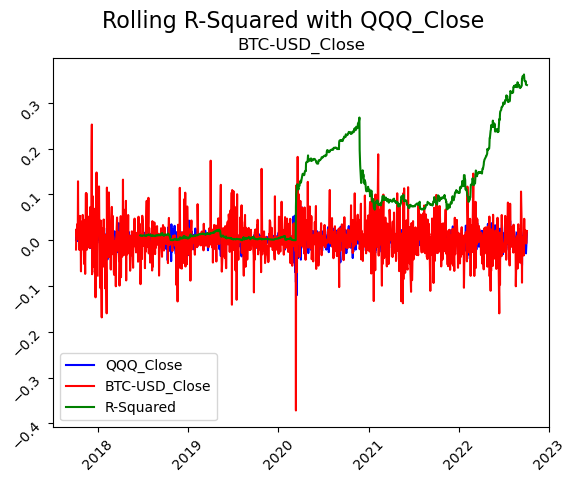

In [18]:
r2 = rsquared(["QQQ"],["BTC-USD"])
r2.ticker_rolling_rsquared(period = "5y", interval='1d', window = 45)
r2.ticker_rolling_rsquared(period = "5y", interval='1d', window = 90)
r2.ticker_rolling_rsquared(period = "5y", interval='1d', window = 180)